## Elimination segmentation
> Inference client

In [64]:
%matplotlib inline

In [2]:
#| default_exp segmentation.elimination
#| export
import dataclasses
import logging
import os
import pathlib
import time

from typing import Any, List, Optional, Tuple

import numpy as np
import torch
import numpy.typing as nptypes

import dataclasses_json
import mlflow
import mmcv
from mmcv.transforms import Compose
from mmdet.utils import get_test_pipeline_cfg
from mmengine.config import Config, ConfigDict
from mmyolo.utils import register_all_modules
import tritonclient.http as httpclient

from csgo_clips_autotrim.experiment_utils.utils import TimeSplitTracker, getLogger
from csgo_clips_autotrim.experiment_utils.config import InferenceConfig

## Setup

In [3]:
#| export
mlflow.set_tracking_uri('https://mlflow.tenzing.shkhr.ovh')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'

logger = getLogger('elimination_segmentation')

def get_model_config(run_id: str) -> os.PathLike:
    """Get model config from mlflow's model store.

    Args:
        run_id (str)

    Returns:
        os.PathLike: Local path to model config.
    """
    return mlflow.artifacts.download_artifacts(artifact_uri=f'runs:/{run_id}/model_config.py')

In [4]:
#| export

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class XYXYBBox:
    """Bounding box representation for image segment.
    NOTE: Bbox dimensions are in [xmin, ymin, xmax, ymax] format.
    """
    dims: List[float]


@dataclasses_json.dataclass_json
@dataclasses.dataclass
class XYWHBBox:
    """Bounding box representation for image segment.
    NOTE: Bbox dimensions are in [xmin, ymin, w, h] format.
    """
    dims: List[float]

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class OCRResult:
    text: str
    confidence: float

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class SegmentationResult:
    bbox: XYXYBBox
    ocr: Optional[OCRResult]

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class EliminationEvent: 
    """Dataclass representing an elimination event.
    """
    event: SegmentationResult
    eliminator: Optional[SegmentationResult] = None
    weapon: Optional[SegmentationResult] = None
    eliminated: Optional[SegmentationResult] = None

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class FrameInfo:
    name: str
    idx: int

@dataclasses_json.dataclass_json
@dataclasses.dataclass
class EliminationSegmentationResult:
    elimination_events: List[EliminationEvent]
    frame_info: Optional[FrameInfo]

@dataclasses.dataclass
class PreprocessResult:
    image: nptypes.ArrayLike
    pad_param: torch.Tensor
    scale_factor: torch.Tensor
    img_shape: Tuple[int]

In [20]:
#| export
register_all_modules()

def preprocess_image(input_img: nptypes.NDArray, model_run_id: str) -> PreprocessResult:
    tt = TimeSplitTracker()
    tt.add('start')
    model_config_path = get_model_config(model_run_id)
    tt.add('get model config')

    # Load evaluation pipeline.
    cfg = Config.fromfile(model_config_path)
    test_pipeline = get_test_pipeline_cfg(cfg)
    test_pipeline[0] = ConfigDict({'type': 'mmdet.LoadImageFromNDArray'})
    test_pipeline = Compose(test_pipeline)
    tt.add('load test pipeline')

    # Load image.
    data, samples = test_pipeline(dict(img=input_img, img_id=0)).values()
    tt.add('load image')

    # Get padding/scaling factors for resizing the image.
    pad_param = samples.get('pad_param', np.array([0, 0, 0, 0], dtype=np.float32))
    pad_param = torch.asarray([pad_param[2], pad_param[0], pad_param[2], pad_param[0]])
    scale_factor = samples.get('scale_factor', [1., 1])
    scale_factor = torch.asarray(scale_factor * 2)
    tt.add('get pad/scale')

    # Reshape and convert to float.
    data = data[np.newaxis, :]
    img = data.numpy()
    img = img.astype(np.float32)
    img /= 255.0
    tt.add('reshape and convert dtype')

    img_shape = samples.get('ori_shape', input_img.shape[:2])

    if logger.isEnabledFor(logging.DEBUG):
        tt.show_summary()

    return PreprocessResult(img, pad_param, scale_factor, img_shape)

In [33]:
#| export
def get_inference_result(preprocess_result: PreprocessResult, inference_config: InferenceConfig) -> List[XYXYBBox]:
    tt = TimeSplitTracker()

    tt.add('start')
    client = httpclient.InferenceServerClient(url=inference_config.triton_url)
    tt.add('client creation')

    img, pad_params, scale_factor, img_shape = dataclasses.astuple(preprocess_result)

    inputs = httpclient.InferInput('input', img.shape, datatype='FP32')
    inputs.set_data_from_numpy(img, binary_data=True)
    tt.add('set data')

    output_bbox = httpclient.InferRequestedOutput('dets', binary_data=True)
    output_labels = httpclient.InferRequestedOutput('labels', binary_data=True)
    tt.add('create output')
    
    # Perform inference.
    results = client.infer(model_name=inference_config.triton_model_name, inputs=[inputs], outputs=[output_bbox, output_labels])
    tt.add('inference')

    inference_output = results.as_numpy('dets')

    bboxes = inference_output[:, :, :-1]
    scores = inference_output[:, :, -1]
    bboxes -= pad_params.numpy()
    bboxes /= scale_factor.numpy()

    num_batches = bboxes.shape[0]

    detections = []

    for batch in range(num_batches):
        for bbox, score in zip(bboxes[batch], scores[batch]):
            if score < inference_config.score_threshold:
                continue

            detections.append(XYXYBBox(bbox.tolist()))

    return detections

def segment_elimination_events(preprocess_result: PreprocessResult, image_path: os.PathLike, inference_config: InferenceConfig) -> EliminationSegmentationResult:
    tt = TimeSplitTracker()
    tt.add('start')

    detections = get_inference_result(preprocess_result, inference_config)
    detected_events = [EliminationEvent(event=SegmentationResult(bbox, None)) for bbox in detections]
    tt.add('transform results')

    if logger.isEnabledFor(logging.DEBUG):
        tt.show_summary()

    frame_info = None
    try:
        frame_name = pathlib.Path(image_path).stem
        *_, frame_idx = frame_name.split('_')
        frame_idx = int(frame_idx)
        frame_info = FrameInfo(name=frame_name, idx=frame_idx)
    except:
        logging.warning('Could not find frame info from file name.')

    return EliminationSegmentationResult(elimination_events=detected_events, frame_info=frame_info)

In [34]:
SAMPLE_IMAGE_PATH = pathlib.Path('../data/difficult_test.png')
assert SAMPLE_IMAGE_PATH.exists(), "Sample image does not exist"

ELIMINATION_MODEL_RUN_ID = '254e228656e348078b8663502a68065a'
ELIMINATION_CONFIG_FILE_NAME = 'yolov8_s_fast_1xb12-40e_csgo.py'

SAMPLE_MODEL_CONFIG_PATH = get_model_config(ELIMINATION_MODEL_RUN_ID)


In [35]:
elimination_inference_config = InferenceConfig(
    mlflow_artifact_run_id=ELIMINATION_MODEL_RUN_ID,
    triton_model_name='csgo-elimination-segmentation-yolov8',
    triton_url='localhost:8000',
    score_threshold=0.5)


input_img = mmcv.imread(SAMPLE_IMAGE_PATH)
rgb = mmcv.imconvert(input_img, 'bgr', 'rgb')

preprocess_result = preprocess_image(rgb, elimination_inference_config.mlflow_artifact_run_id)

segmentation_result = segment_elimination_events(preprocess_result, SAMPLE_IMAGE_PATH, elimination_inference_config)
segmentation_result

[WARNING] 2023-08-02 01:10:42,210 root        : Could not find frame info from file name.


EliminationSegmentationResult(elimination_events=[EliminationEvent(event=SegmentationResult(bbox=XYXYBBox(dims=[1034.5565185546875, 51.17595672607422, 1277.2362060546875, 79.37998962402344]), ocr=None), eliminator=None, weapon=None, eliminated=None), EliminationEvent(event=SegmentationResult(bbox=XYXYBBox(dims=[1018.419921875, 78.74056243896484, 1277.1624755859375, 106.79358673095703]), ocr=None), eliminator=None, weapon=None, eliminated=None)], frame_info=None)

In [66]:
import matplotlib.pyplot as plt

from csgo_clips_autotrim.segmentation.utils import show_mask, box_to_mask


def show_event(event: EliminationEvent, h: int, w: int):
    bbox = event.event.bbox
    show_mask(box_to_mask(bbox.dims, h, w), plt.gca())

    if event.weapon:
        weapon_bbox = event.weapon.bbox
        show_mask(box_to_mask(weapon_bbox.dims, h, w), plt.gca(), random_color=True)

def show_events(image_path: os.PathLike, elimination_eents: List[EliminationEvent]):
    bgr = mmcv.imread(image_path)
    rgb = mmcv.imconvert(bgr, 'bgr', 'rgb')

    plt.imshow(rgb)

    h, w = rgb.shape[:2]

    for event in elimination_eents:
        show_event(event, h, w)

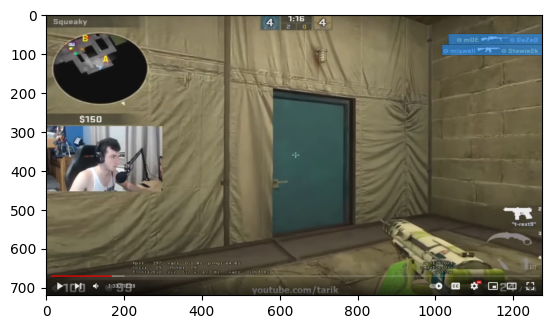

In [67]:
show_events(SAMPLE_IMAGE_PATH, segmentation_result.elimination_events)

In [68]:
def show_cropped_event(image_path: os.PathLike, elimination_event: EliminationEvent):
    bgr = mmcv.imread(image_path)
    rgb = mmcv.imconvert(bgr, 'bgr', 'rgb')

    bbox = [int(x) for x in elimination_event.event.bbox.dims]

    cropped_img = rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    plt.imshow(cropped_img)
    ...

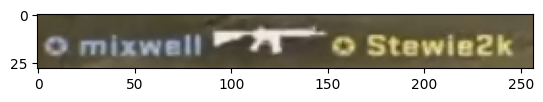

In [69]:
show_cropped_event(SAMPLE_IMAGE_PATH, segmentation_result.elimination_events[1])

### Segment out weapon information to extract other details

In [70]:
#| export
def get_weapon_segmentation_input(input_img: nptypes.ArrayLike, elimination_event: EliminationEvent) -> nptypes.ArrayLike:
    """Get the input image crop for the given elimination event.

    Args:
        input_img (nptypes.ArrayLike): _description_
        elimination_event (EliminationEvent): _description_

    Returns:
        nptypes.ArrayLike: _description_
    """
    elimination_bbox = elimination_event.event.bbox

    xmin, ymin, xmax, ymax = elimination_bbox.dims
    xmin = int(xmin)
    ymin = int(ymin)
    xmax = int(xmax)
    ymax = int(ymax)

    return input_img[ymin:ymax, xmin:xmax, :]

def segment_weapon(elimination_event: EliminationEvent, preprocess_result: PreprocessResult, inference_config: InferenceConfig) -> EliminationEvent:
    """Add weapon information to the current dataset.

    Args:
        elimination_event (EliminationEvent): _description_
        preprocess_result (PreprocessResult): _description_
        inference_config (InferenceConfig): _description_

    Returns:
        EliminationEvent: _description_
    """
    tt = TimeSplitTracker()
    tt.add('start')
    detections = get_inference_result(preprocess_result, inference_config)
    tt.add('inference')

    assert len(detections) > 0, 'Did not find any weapon in given elimination event'
    assert len(detections) < 2, 'Found multiple weapons in the given elimination event'

    # Translate the bboxes to the original image.
    weapon_bbox = detections[0].dims
    event_bbox = elimination_event.event.bbox
    x_min, y_min, *_ = event_bbox.dims
    weapon_bbox_translated = XYXYBBox([weapon_bbox[0] + x_min, weapon_bbox[1] + y_min, weapon_bbox[2] + x_min, weapon_bbox[3] + y_min])

    elimination_event_with_weapon_info = dataclasses.replace(elimination_event,
                                                            weapon=SegmentationResult(weapon_bbox_translated, None))

    return elimination_event_with_weapon_info

In [71]:
WEAPON_MODEL_RUN_ID = 'ab4eddb8e281440c882d5d8771844c9c'

In [72]:
segmentation_result

EliminationSegmentationResult(elimination_events=[EliminationEvent(event=SegmentationResult(bbox=XYXYBBox(dims=[1034.5565185546875, 51.17595672607422, 1277.2362060546875, 79.37998962402344]), ocr=None), eliminator=None, weapon=None, eliminated=None), EliminationEvent(event=SegmentationResult(bbox=XYXYBBox(dims=[1018.419921875, 78.74056243896484, 1277.1624755859375, 106.79358673095703]), ocr=None), eliminator=None, weapon=None, eliminated=None)], frame_info=None)

In [73]:
sample_elimination_event = segmentation_result.elimination_events[0]
weapon_inference_config = InferenceConfig(
    mlflow_artifact_run_id=WEAPON_MODEL_RUN_ID,
    triton_model_name='csgo-elimination-weapon-segmentation-yolov8',
    triton_url='localhost:8000',
    score_threshold=0.5)

weapon_segmentation_input = get_weapon_segmentation_input(rgb, sample_elimination_event)
weapon_segmentation_input_prep = preprocess_image(weapon_segmentation_input, WEAPON_MODEL_RUN_ID)
weapon_segmentation_result = segment_weapon(sample_elimination_event, weapon_segmentation_input_prep, weapon_inference_config)

In [74]:
weapon_segmentation_result

EliminationEvent(event=SegmentationResult(bbox=XYXYBBox(dims=[1034.5565185546875, 51.17595672607422, 1277.2362060546875, 79.37998962402344]), ocr=None), eliminator=None, weapon=SegmentationResult(bbox=XYXYBBox(dims=[1118.0841445922852, 55.911529541015625, 1191.13671875, 74.43503761291504]), ocr=None), eliminated=None)

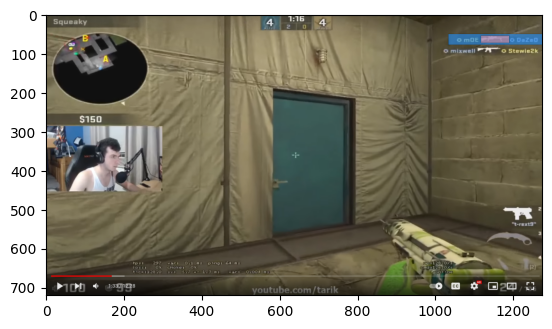

In [75]:
plt.imshow(rgb)

h, w = rgb.shape[:2]

show_event(weapon_segmentation_result, h, w)

In [ ]:
#| export
def get_eliminator_bbox(event: EliminationEvent) -> XYXYBBox:
    """Get an estimation of the eliminator bbox based on outer dimensions
    and weapon bbox.

    Args:
        event (EliminationEvent)

    Returns:
        XYXYBBox: Eliminator bbox
    """
    eliminator_xmin = event.event.bbox.dims[0]
    eliminator_ymin = event.weapon.bbox.dims[1]
    eliminator_xmax = event.weapon.bbox.dims[0]
    eliminator_ymax = event.weapon.bbox.dims[3]

    return XYXYBBox(dims=[eliminator_xmin, eliminator_ymin, eliminator_xmax, eliminator_ymax])

def get_eliminated_bbox(event: EliminationEvent) -> XYXYBBox:
    """Get an estimation of the eliminator bbox based on outer dimensions
    and weapon bbox.

    Args:
        event (EliminationEvent)

    Returns:
        XYXYBBox: Eliminator bbox
    """
    eliminated_xmin = event.weapon.bbox.dims[2]
    eliminated_ymin = event.weapon.bbox.dims[1]
    eliminated_xmax = event.event.bbox.dims[2]
    eliminated_ymax = event.weapon.bbox.dims[3]

    return XYXYBBox(dims=[eliminated_xmin, eliminated_ymin, eliminated_xmax, eliminated_ymax])